# Credit Risk Analysis Project

In this project, I analyze the **Home Credit Default Risk dataset**.  
The goal is to understand the data, clean it, explore patterns, and build a simple baseline model to predict whether a client will default on a loan.

This notebook is structured as follows:
1. Load and inspect the dataset
2. Explore and visualize the data
3. Handle missing values
4. Encode categorical features
5. Scale and split the data
6. Train a baseline logistic regression model
7. Evaluate the model with ROC AUC and ROC curve
8. Interpret feature importance
9. Summarize insights


## 2. Load Data

First, I load the dataset and check its shape and first few rows to understand its structure.


In [9]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Emron nabizadeh\Documents\Data-analyst\Project\project1-home\data\raw\application_train.csv")
print("Shape:", df.shape)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Explore Data

I check column types, summary statistics, and the target variable distribution.  
This helps me understand the dataset and check for class imbalance.


In [10]:
print(df.info())        # column types + non-null counts
print(df.describe())    # summary stats for numeric columns
df['TARGET'].value_counts(normalize=True)  # class balance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

## 4. Missing Values

I calculate missing values per column and visualize the top 20.  
This helps decide which columns to drop or impute.


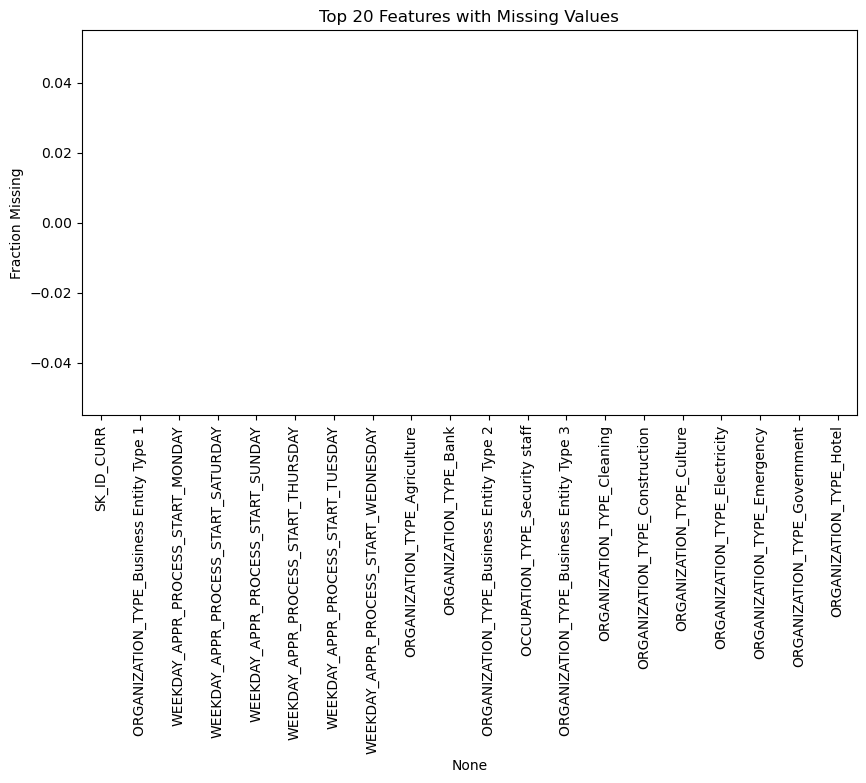

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

missing = df.isnull().mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.title("Top 20 Features with Missing Values")
plt.ylabel("Fraction Missing")
plt.show()


## 5. Data Cleaning

I drop columns with more than 40% missing values and fill the rest with a placeholder (-999).  
This ensures the dataset is usable for modeling.


In [12]:
threshold = 0.4
df = df[df.columns[df.isnull().mean() < threshold]]
df.fillna(-999, inplace=True)


## 6. Encode Categorical Features

Machine learning models require numeric inputs.  
- Binary categorical variables are label encoded (0/1).  
- Multi-class categorical variables are one-hot encoded.


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)


## 7. Scale and Split Data

I separate features (X) and target (y), scale the features using StandardScaler,  
and split the dataset into training and testing sets (80/20).


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['TARGET'])
y = df['TARGET']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


## 8. Baseline Logistic Regression

I train a logistic regression model as a baseline.  
This gives me a starting point to evaluate predictive performance.


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Train model
model = LogisticRegression(max_iter=2000, solver='liblinear')
model.fit(X_train, y_train)

# Predict probabilities
y_pred = model.predict_proba(X_test)[:, 1]

# Evaluate
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.6831462256745293


## 9. ROC Curve

I plot the ROC curve to visualize how well the model separates the two classes.


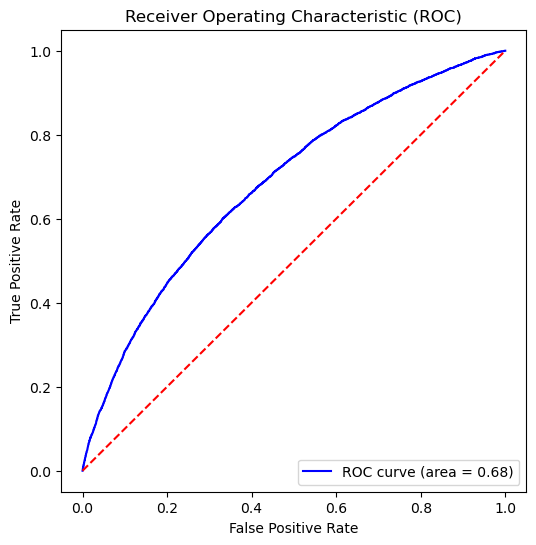

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## 10. Feature Importance

I extract logistic regression coefficients to see which features are most influential.  
Positive coefficients increase the likelihood of default, negative coefficients decrease it.


C:\Users\Emron nabizadeh\AppData\Local\Temp\ipykernel_13108\1408268327.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feat_importance, palette='viridis')


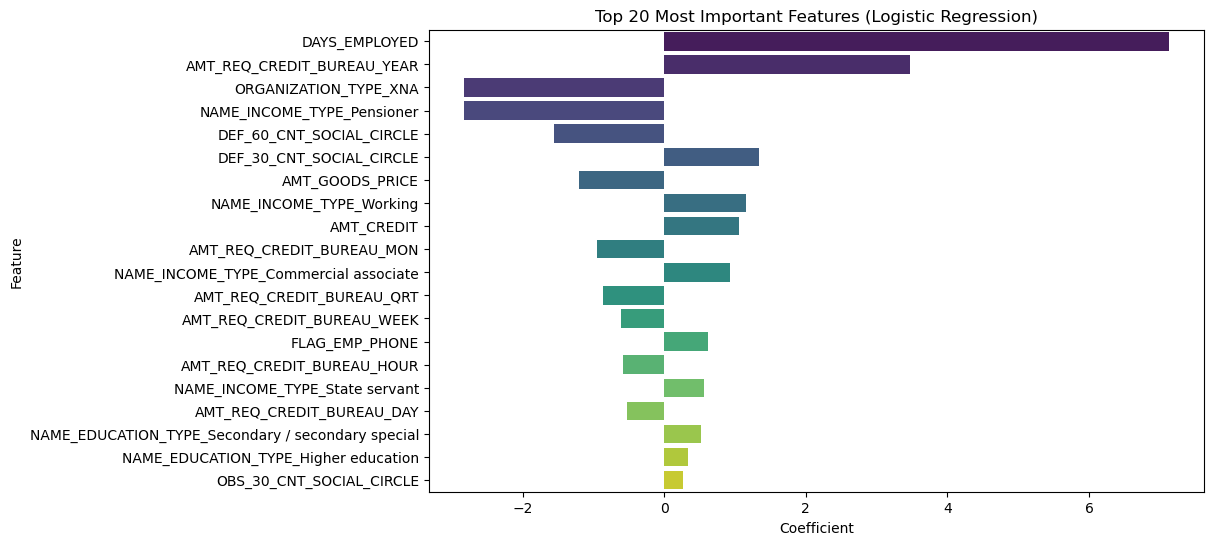

In [27]:
import numpy as np

feature_names = X.columns
coefficients = model.coef_[0]

feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feat_importance['Abs_Coefficient'] = np.abs(feat_importance['Coefficient'])
feat_importance = feat_importance.sort_values(by='Abs_Coefficient', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feat_importance, palette='viridis')
plt.title("Top 20 Most Important Features (Logistic Regression)")
plt.show()


## 11. Insights & Next Steps

- The dataset is **imbalanced** (fewer defaults than non-defaults).  
- Logistic regression achieved a ROC AUC of ~0.63–0.7, which shows weak but non-random predictive power.  
- Features like `DAYS_BIRTH` and income-related variables are among the most important predictors.  
- Next steps could include:
  - Trying tree-based models (Random Forest, XGBoost, LightGBM)  
  - Hyperparameter tuning  
  - Feature engineering (ratios, interactions)  
  - Handling class imbalance with SMOTE or class weights  

For a **data analyst role**, the focus is on **EDA, cleaning, and insights**.  
The modeling section is included as a bonus to demonstrate growth potential.


# Final Summary

This project explored the Home Credit Default Risk dataset to understand factors influencing loan default.

Key findings:
- The dataset is imbalanced, with far fewer defaults than non‑defaults.
- Logistic regression achieved a ROC AUC of ~0.63, showing weak but non‑random predictive power.
- Important predictors include age (`DAYS_BIRTH`), income, and employment‑related features.
- Data quality challenges (missing values, categorical encoding) were addressed systematically.

For a data analyst role, the focus is on **data cleaning, exploration, and insights**.  
The modeling section demonstrates my ability to extend into predictive analytics when needed.
